# Intro à GeoPandas

## Objectifs

Dans ce tutoriel, nous allons explorer l'utilisation de GeoPandas pour manipuler des données géospatiales. GeoPandas est une extension de Pandas, et si vous êtes déjà familier avec Pandas, apprendre GeoPandas sera une transition naturelle. GeoPandas ajoute des capacités géospatiales aux DataFrames de Pandas, ce qui en fait un outil puissant pour analyser des données géographiques.

Nous allons découvrir les possibilités de GeoPandas à l'aide de deux exemples:

- Manipulation des données géospatiales des pays du monde : lecture, jointure, calculs géographiques et analyse statistique.
- Analyse géospatiale des données OpenStreetMap en Estonie : calcul des distances, agrégation des données, et statistiques géographiques.

## Indice démographique des pays du monde

Dans cet exemple, nous allons calculer un indice démographique pour les pays du monde, à l'aide des données de la Banque mondiale et des géométries de [Natural Earth](https://naturalearthdata.com).

Avant de commencer, nous devons obtenir les données nécessaires à l'analyse. Nous faisons cela avec le module `pooch`. Il faut d'abord s'assurer qu'il est installé:

In [ ]:
!pip install pooch

Les données sont prêtes à être téléchargées depuis l'URL suivante, sous forme d'une archive ZIP: [https://files.swisscarto.ch/geoinf1/demographie-monde.zip](https://files.swisscarto.ch/geoinf1/demographie-monde.zip). Nous pouvons le télécharger directement avec Pooch:

In [12]:
import pooch

In [14]:
data_files = pooch.retrieve(
    url = 'https://files.swisscarto.ch/geoinf1/demographie-monde.zip',
    known_hash = None,
    processor = pooch.Unzip()
)

Cette opération a permis de télécharger le fichier dans un dossier temporaire sur le disque dur et de le décompresser. `data_files` contient maintenant une liste avec tous les fichiers contenus dans l'archive ZIP.

### Lecture du fichier Shape des pays du monde

Nous allons maintenant charger le fichier Shape des pays du monde à l'aide de GeoPandas. Assurons-nous d'abord que GeoPandas est installé:

In [ ]:
!pip install geopandas

Nous pouvons import GeoPandas, nous utilisons le nom court `gdp` pour nommer le module:

In [19]:
import geopandas as gdp

Nous devons maintenant obtenir le chemin d'accès du fichier Shape. L'archive ZIP contient un seul fichier Shape, nous pouvons donc filtrer les fichiers à l'aide de l'extension:

In [20]:
pays_shp_path = [df for df in data_files if df.endswith('.shp')][0]
pays_shp_path

'/home/ck/.cache/pooch/1e46bb8437871d9c298d7e2d61618148-demographie-monde.zip.unzip/demographie-monde/ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp'

Le chargement du fichier Shape se fait simplement avec la fonction `read_file`:

In [22]:
pays = gdp.read_file(pays_shp_path)

Inspecter le contenu du fichier:

<Axes: >

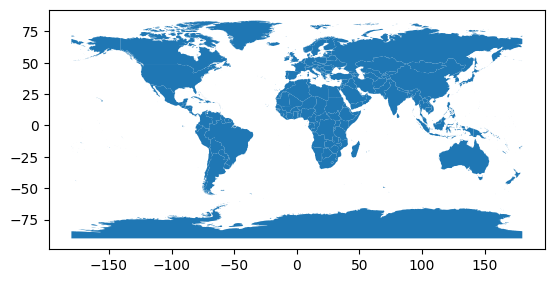

In [24]:
pays.plot()

### Lecture du fichier des données

Les données se trouvent dans un fichier TSV qui était à l'intérieur de l'archive ZIP. Nous pouvons obtenir le chemin d'accès comme avant pour le fichier Shape, sauf que nous cherchons pour l'extension `.tsv`:

In [25]:
wb_data_path = [df for df in data_files if df.endswith('.tsv')][0]
wb_data_path

'/home/ck/.cache/pooch/1e46bb8437871d9c298d7e2d61618148-demographie-monde.zip.unzip/demographie-monde/wb_extract_development_indicators_2023/wb_extract_development_indicators_2023.tsv'

Nous pouvons lire le fichier avec Pandas. Il faut l'importer avant:

In [27]:
import pandas as pd

In [ ]:
wb_data = pd.read_csv(wb_data_path, sep='\t')
print(wb_data.head())

Nous pouvons maintenant faire une jointure par attribut des données aux DataFrame des pays. Pour ceci, nous devons identifier deux colonnes qui contiennent la même information.

Nous pouvons inspecter les colonnes des deux DataFrames:

In [ ]:
pays.columns.tolist()

In [ ]:
wb_data.columns.tolist()

Nous allons utiliser la colonne `WB_A3` du DataFrame des pays, et la colonne `Country Code` du DataFrame des données de la Banque mondiale.

Nous pouvons maintenant faire la jointure avec la fonction `merge`:

In [35]:
pays_data = pays.merge(wb_data, left_on='WB_A3', right_on='Country Code', how='left')

### Calculer un indicateur d'âge

Nous allons calculer un indicateur d’âge, défini comme le rapport entre la population âgée (65 ans et plus) et la population jeune (0-14 ans), ou plus extactement le nombre de personnes âgées (65 ans et plus) pour 100 personnes jeunes (0 à 14 ans).

Le calcul est assez simple une fois que l'on a trouvé les noms des colonnes. Vu que les noms des colonnes ne sont vraiment pas simples, nous le gardons dans une variable:

In [37]:
indic_vieux = '2023 [YR2023] - Population ages 65 and above, total [SP.POP.65UP.TO]'
indic_jeunes = '2023 [YR2023] - Population ages 0-14, total [SP.POP.0014.TO]'

Avant de procéder au calcul, nous devons nous assurer que les valeurs sont numériques et que les valeurs non numériques sont des `NaN` (avec `errors = 'coerce'`):

In [41]:
pays_data[indic_vieux] = pd.to_numeric(pays_data[indic_vieux], errors='coerce')
pays_data[indic_jeunes] = pd.to_numeric(pays_data[indic_jeunes], errors='coerce')

Ensuite le calcul en tant que tel:

In [43]:
pays_data['indic_age'] = pays_data[indic_vieux] / pays_data[indic_jeunes] * 100

Vérifier le calcul:

In [44]:
pays_data['indic_age']

0        8.182359
1        4.166559
2        6.780921
3       43.005289
4       32.965688
          ...    
237      5.590231
238           NaN
239           NaN
240    112.228705
241     21.039536
Name: indic_age, Length: 242, dtype: float64

### Créer des classes et faire le décompte des personnes

Nous allons maintenant diviser les pays en 5 classes selon l'indicateur d'âge. chaque classe aura à peu près le même nombre de pays. Nous utilisons la fonction `qcut` de Pandas pour cela. Consultez la documentation Pandas pour en savoir plus:

In [46]:
pays_data['indic_age_cls'] = pd.qcut(pays_data['indic_age'], q=5, labels=False)

Et inspecter le résultat:

In [48]:
print(pays_data[['NAME', 'indic_age_cls']].head())

        NAME  indic_age_cls
0   Zimbabwe            0.0
1     Zambia            0.0
2      Yemen            0.0
3    Vietnam            2.0
4  Venezuela            2.0


Regardons le résultat sur une carte rapide:

<Axes: >

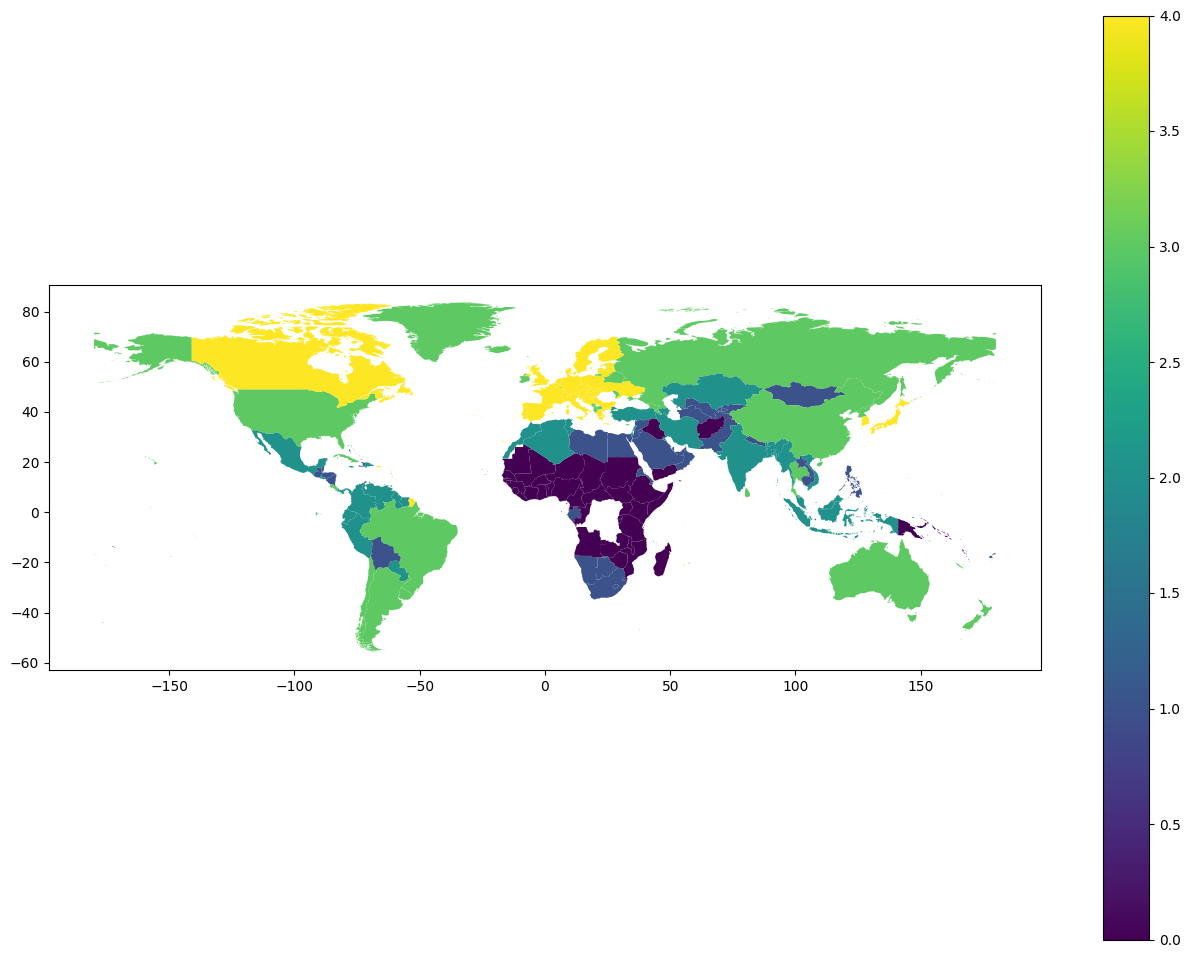

In [51]:
pays_data.plot(
    column = 'indic_age_cls',
    cmap = 'viridis',
    legend = True,
    figsize = (16, 12)
)

Nous avons certainement vu des meilleures cartes... mais elle fait l'affaire pour le moment. L'indicateur d'âge représente le ratio vieux / jeunes, et plus l'indicateur est élevé, plus il y a de personnes âgées par rapport aux jeunes. Il représente donc une facette du veillissement de la population, avec surtout les pays occidentaux ayant une valeur élevée.

Nous pouvons maintenant compter combien de personnes appartiennent à quelle classe de l'indicateur d'âge. Cette opération d'agrégation s'appelle un **«group by»** et on groupe toutes les entités avec la même valeur. Ensuite, on peut calculer des statistiques sur ces groupes, en l'occurrence la somme:

In [58]:
col_pop = '2023 [YR2023] - Population, total [SP.POP.TOTL]'
pays_data[col_pop] = pd.to_numeric(pays_data[col_pop], errors='coerce')
pop_par_classe = pays_data.groupby('indic_age_cls')[col_pop].sum()

In [59]:
pop_par_classe

indic_age_cls
0.0    1.194982e+09
1.0    8.251452e+08
2.0    2.685410e+09
3.0    2.379984e+09
4.0    7.809146e+08
Name: 2023 [YR2023] - Population, total [SP.POP.TOTL], dtype: float64

Nous pouvons maintenant faire un graphique avec Matplotlib:

In [60]:
import matplotlib.pyplot as plt

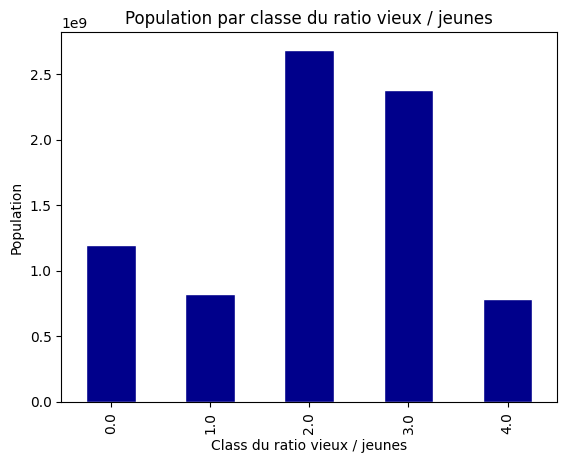

In [65]:
pop_par_classe.plot(kind="bar", color="darkblue", edgecolor="white")
plt.title("Population par classe du ratio vieux / jeunes")
plt.xlabel("Class du ratio vieux / jeunes")
plt.ylabel("Population")
plt.show()

Pour finir cette partie, nous écrivons le jeu de données final dans un fichier Parquet:

In [67]:
pays_data.to_file('pays_data.gpkg', driver='GPKG', layer='pays_data') 